## Refine epithelial cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=True,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Epi.pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 56869 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [8]:
list(adata.obs.organ_unified.unique())

['ileum',
 'caecum',
 'rectum',
 'sigmoid colon',
 'colon',
 'ascending colon',
 'small intestine',
 'stomach']

In [9]:
adata = adata[adata.obs.organ_unified.isin(['stomach'])].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 29381 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [11]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Epi_stomach_method2_20230226.csv.gz',compression='gzip',index_col=0)

In [12]:
adata_scanvi

LV1       LV2       LV3       LV4       LV5  \
index                                                                           
AAACCTGGTTCCACGG-GSM5101014 -0.025055  0.889893  0.121449  0.987067 -2.541664   
AAACCTGTCACGCGGT-GSM5101014  0.126843  0.940291  0.020037 -0.172433 -1.213913   
AAACCTGTCCAATGGT-GSM5101014  0.388799  1.798071  0.048355 -0.940484 -1.757040   
AAACCTGTCCCTAACC-GSM5101014  1.044099  1.047772  0.021971  0.880272 -0.965975   
AAACGGGAGAGTACCG-GSM5101014  0.150430  0.606202  0.018474  0.913326 -0.338516   
...                               ...       ...       ...       ...       ...   
TTTGCGCTCAGGATCT-GSM4546346 -2.328287  0.449437  0.016483  0.506281 -0.349298   
TTTGGTTAGTGACTCT-GSM4546346 -1.767008  0.514987 -0.031408  1.002111 -0.768243   
TTTGGTTCAAACTGTC-GSM4546346  2.049998  0.502613  0.005162 -0.370679  1.176120   
TTTGGTTCAGCGTAAG-GSM4546346 -2.481558  0.445507  0.083731 -0.230925 -0.138752   
TTTGGTTTCAGGTTCA-GSM4546346  1.799603  1.171755  0.005117  0.413190  1.047709   

                                  LV6       LV7       LV8       LV9      LV10  \
index                                                                           
AAACCTGGTTCCACGG-GSM5101014 -0.058142 -0.044790  0.146847  0.055928  0.003618   
AAACCTGTCACGCGGT-GSM5101014 -0.044740 -0.000993  0.042796 -0.032107 -0.033768   
AAACCTGTCCAATGGT-GSM5101014 -0.088824 -0.030574  0.115651 -0.008967 -0.052639   
AAACCTGTCCCTAACC-GSM5101014 -0.007191 -0.032586  0.107156  0.056604 -0.043163   
AAACGGGAGAGTACCG-GSM5101014 -0.057394  0.016461  0.016751  0.000782 -0.012406   
...                               ...       ...       ...       ...       ...   
TTTGCGCTCAGGATCT-GSM4546346 -0.015936 -0.004751 -0.000363  0.046095 -0.052557   
TTTGGTTAGTGACTCT-GSM4546346 -0.003701 -0.039808  0.023162  0.028875 -0.106638   
TTTGGTTCAAACTGTC-GSM4546346  0.135818  0.011708 -0.061063  0.036020  0.043064   
TTTGGTTCAGCGTAAG-GSM4546346  0.060109 -0.061380  0.121501  0.068031  0.053118   
TTTGGTTTCAGGTTCA-GSM4546346  0.114406  0.010397 -0.046994  0.061995  0.021003   

                                 LV11      LV12      LV13      LV14      LV15  \
index                                                                           
AAACCTGGTTCCACGG-GSM5101014  0.014077 -0.031011 -0.718986 -0.424648  0.087391   
AAACCTGTCACGCGGT-GSM5101014  0.049372  0.016405 -0.708168 -0.317102  0.044843   
AAACCTGTCCAATGGT-GSM5101014  0.028476  0.018434 -0.538627 -0.484586  0.118537   
AAACCTGTCCCTAACC-GSM5101014  0.080907 -0.083320 -0.086578  0.929621  0.054068   
AAACGGGAGAGTACCG-GSM5101014  0.039757 -0.039229 -0.357961  0.858247  0.002572   
...                               ...       ...       ...       ...       ...   
TTTGCGCTCAGGATCT-GSM4546346  0.142270 -0.080415  0.541903  0.468405  0.032708   
TTTGGTTAGTGACTCT-GSM4546346  0.105413 -0.096340 -0.019220  0.441217  0.049059   
TTTGGTTCAAACTGTC-GSM4546346  0.038082 -0.097957  1.042476 -0.539892  0.026605   
TTTGGTTCAGCGTAAG-GSM4546346  0.094269 -0.058998 -0.160212  0.812862  0.042935   
TTTGGTTTCAGGTTCA-GSM4546346  0.034328 -0.104884  1.859375 -0.335425  0.039190   

                                 LV16      LV17      LV18      LV19      LV20  
index                                                                          
AAACCTGGTTCCACGG-GSM5101014  0.419752  0.453669 -0.255607  0.130398 -0.735942  
AAACCTGTCACGCGGT-GSM5101014 -1.349654  0.746109  1.467191  0.065862  0.118387  
AAACCTGTCCAATGGT-GSM5101014 -0.872372 -0.062469 -0.131378  0.145966 -0.208324  
AAACCTGTCCCTAACC-GSM5101014  0.294104 -0.480644 -0.299769 -0.005435  0.739974  
AAACGGGAGAGTACCG-GSM5101014 -0.419116  0.423387  1.106969 -0.058074 -0.506812  
...                               ...       ...       ...       ...       ...  
TTTGCGCTCAGGATCT-GSM4546346  0.017921 -0.619122  0.277961 -0.167358  1.230665  
TTTGGTTAGTGACTCT-GSM4546346 -0.733963 -0.996164 -0.186415 -0.076054  2.112002  
TTTGGTTCAAACTGTC-GSM4546346  1.905586  0.110794 -0.013406 -0.114971  0.7

In [13]:
adata.obsm['X_scANVI'] = adata_scanvi

In [14]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Epi_stomach_method2_20230226.csv',index_col=0)

In [15]:
adata_meta

latent_cell_probability  latent_RT_efficiency  \
index                                                                        
AAACCTGGTTCCACGG-GSM5101014                 0.999850              1.026135   
AAACCTGTCACGCGGT-GSM5101014                 0.999951              1.635007   
AAACCTGTCCAATGGT-GSM5101014                 0.999979              1.445156   
AAACCTGTCCCTAACC-GSM5101014                 0.999971              1.577106   
AAACGGGAGAGTACCG-GSM5101014                 0.998578              0.727382   
...                                              ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346                 0.999774              1.340966   
TTTGGTTAGTGACTCT-GSM4546346                 0.999709              1.162290   
TTTGGTTCAAACTGTC-GSM4546346                 0.999884              1.969957   
TTTGGTTCAGCGTAAG-GSM4546346                 0.999862              1.428681   
TTTGGTTTCAGGTTCA-GSM4546346                 0.999940              2.888317   

                              cecilia22_predH  cecilia22_predH_prob  \
index                                                                 
AAACCTGGTTCCACGG-GSM5101014           T cells              0.064910   
AAACCTGTCACGCGGT-GSM5101014  Epithelial cells              0.992968   
AAACCTGTCCAATGGT-GSM5101014  Epithelial cells              0.997977   
AAACCTGTCCCTAACC-GSM5101014  Epithelial cells              0.602373   
AAACGGGAGAGTACCG-GSM5101014           T cells              0.821998   
...                                       ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346      Plasma cells              0.896203   
TTTGGTTAGTGACTCT-GSM4546346      Plasma cells              0.162929   
TTTGGTTCAAACTGTC-GSM4546346  Epithelial cells              0.001299   
TTTGGTTCAGCGTAAG-GSM4546346      Plasma cells              0.708003   
TTTGGTTTCAGGTTCA-GSM4546346  Epithelial cells              0.025135   

                            cecilia22_predH_uncertain  \
index                                                   
AAACCTGGTTCCACGG-GSM5101014                 Uncertain   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells   
AAACCTGTCCAATGGT-GSM5101014          Epithelial cells   
AAACCTGTCCCTAACC-GSM5101014          Epithelial cells   
AAACGGGAGAGTACCG-GSM5101014                   T cells   
...                                               ...   
TTTGCGCTCAGGATCT-GSM4546346              Plasma cells   
TTTGGTTAGTGACTCT-GSM4546346                 Uncertain   
TTTGGTTCAAACTGTC-GSM4546346                 Uncertain   
TTTGGTTCAGCGTAAG-GSM4546346              Plasma cells   
TTTGGTTTCAGGTTCA-GSM4546346                 Uncertain   

                                      cecilia22_predL  cecilia22_predL_prob  \
index                                                                         
AAACCTGGTTCCACGG-GSM5101014  Tcm/Naive helper T cells              0.080985   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells              0.997998   
AAACCTGTCCAATGGT-GSM5101014          Epithelial cells              0.998869   
AAACCTGTCCCTAACC-GSM5101014          Epithelial cells              0.560122   
AAACGGGAGAGTACCG-GSM5101014  Tcm/Naive helper T cells              0.055553   
...                                               ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346          Epithelial cells              0.578191   
TTTGGTTAGTGACTCT-GSM4546346              Plasma cells              0.016857   
TTTGGTTCAAACTGTC-GSM4546346          Epithelial cells              0.000933   
TTTGGTTCAGCGTAAG-GSM4546346              Plasma cells              0.246943   
TTTGGTTTCAGGTTCA-GSM4546346          Epithelial cells              0.095139   

                            cecilia22_predL_uncertain elmentaite21_pred  \
index                                                                     
AAACCTGGTTCCACGG-GSM5101014                 Uncertain                TA   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells    Microfold cell   
AAACCTGTCCAATGGT-GSM

In [16]:
adata.obs = adata_meta

In [17]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


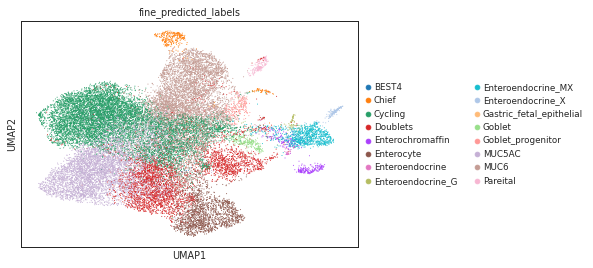

In [18]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

In [19]:
adata.obs.donor_disease.unique()

['cancer']
Categories (1, object): ['cancer']

In [20]:
adata.obs['disease'] = adata.obs['donor_category'].astype(str) + '_' + adata.obs['donor_disease'].astype(str)

In [21]:
list(adata.obs.disease.unique())

['disease_cancer']

In [22]:
adata.obs['donor_disease'] = (adata.obs['disease'].map(lambda x:{
 'disease_cancer':'cancer_gastric',
    'control_control':'control',
 'control_CD':'CD',
 'disease_PIBD':'PIBD',
 'disease_cancer':'cancer_colorectal',
 'disease_CD':'CD',
'disease_UC':'UC'
    
    }.get(x,x)).astype("category"))

In [23]:
adata.obs.donor_disease.unique()

['cancer_colorectal']
Categories (1, object): ['cancer_colorectal']

In [24]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{
'disease_cancer':'cancer_gastric',
    }.get(x,x)).astype("category"))

In [25]:
list(adata.obs.disease.unique())

['cancer_gastric']

In [26]:
adata.obs.fine_predicted_labels.cat.categories

Index(['BEST4', 'Chief', 'Cycling', 'Doublets', 'Enterochromaffin',
       'Enterocyte', 'Enteroendocrine', 'Enteroendocrine_G',
       'Enteroendocrine_MX', 'Enteroendocrine_X', 'Gastric_fetal_epithelial',
       'Goblet', 'Goblet_progenitor', 'MUC5AC', 'MUC6', 'Pareital'],
      dtype='object')

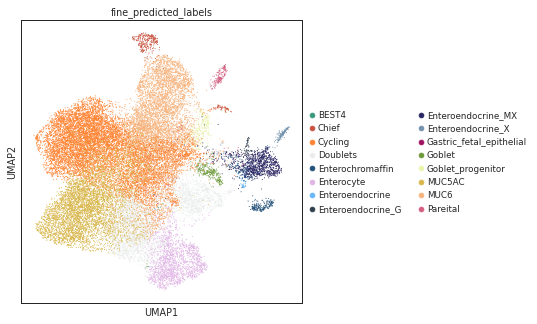

In [27]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#39997c',#BEST4
                                            '#c95340',#chief
                                            '#ff8433',#'Cycling'
                                            '#ebeded',#doublets
                                           '#22517a',#enterochromaffin
                                            '#e1b5e6',#enterocyte
                                           '#68b7fc',#enteroendocrine
                                            '#2f3f4d',#G_enteroendocrine
                                            '#292663',#MX enteroendocrine
                                            '#7292ad',#X_enteroendocrine
                                            '#a01160',#gastric fetal epithelium
                                            '#6c9939',#goblet
                                            '#e9f7ad',#goblet progenitor
                                            '#d9b74a',#MUC5AC
                                            '#f7b37c',#MUC6
                                           '#d45f80',#pareital 
                                                         ],save='Epi_stomach_scanviannot_predicted.pdf')

In [28]:
adata.obs['disease'].cat.categories

Index(['cancer_gastric'], dtype='object')

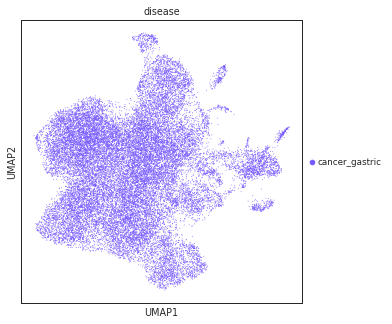

In [29]:
sc.pl.umap(adata,color = 'disease',palette=[
                                            '#7657ff',#gastric cancer
                                           ],size=3)

In [30]:
adata.layers['counts'] = adata.X

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [32]:
marker_genes_dict = { 'BEST4':['BEST4','SPIB','CA7','GUCA2B','CFTR'],
                      'Chief':['PGA5','LIPF','PGA3','PGC','CHIA'],
                     'Cycling':['MKI67','PCLAF','PCNA'],
                     'Enterochromaffin':['HDC','MAOB','LHX5-AS1','KLK11','CHGA'],
                     
                     
                     'Enterocyte':['FABP1','ENPEP','APOA4','PRAP1'], 
                        'Enteroendocrine':['SST','GHRL','GC','ACSL1','S100A1'],
                     'G_enteroendocrine':['GAST','SCGB2A1','CLTRN','CES1','PAX6'],
                     'MX_enteroendocrine':['HOPX','CRYBA2','GCG','MLN','GLS'],
                     'X_enteroendocrine':['GHRL'],
                     'Fetal':['DDIT4','ALDOA','VIM','CCN1'],
                     
                     
                     'Goblet':['MUC2','TFF3','SPINK4','FCGBP'],
                     'Goblet_progenitor':['ODAM','CLDN2','OLFM4'],
                        'Surface Foveolar':['MUC5AC','GKN1','GKN2'],
                     'Mucous Gland Neck':['MUC6','AQP5','BPIFB1'],
   
                     'Pareital':['ATP4A','ATP4B','CBLIF','GPR155','MFSD4A']
                    
                       
                     
                     
                     
                     
}

In [33]:
adata

AnnData object with n_obs × n_vars = 29381 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


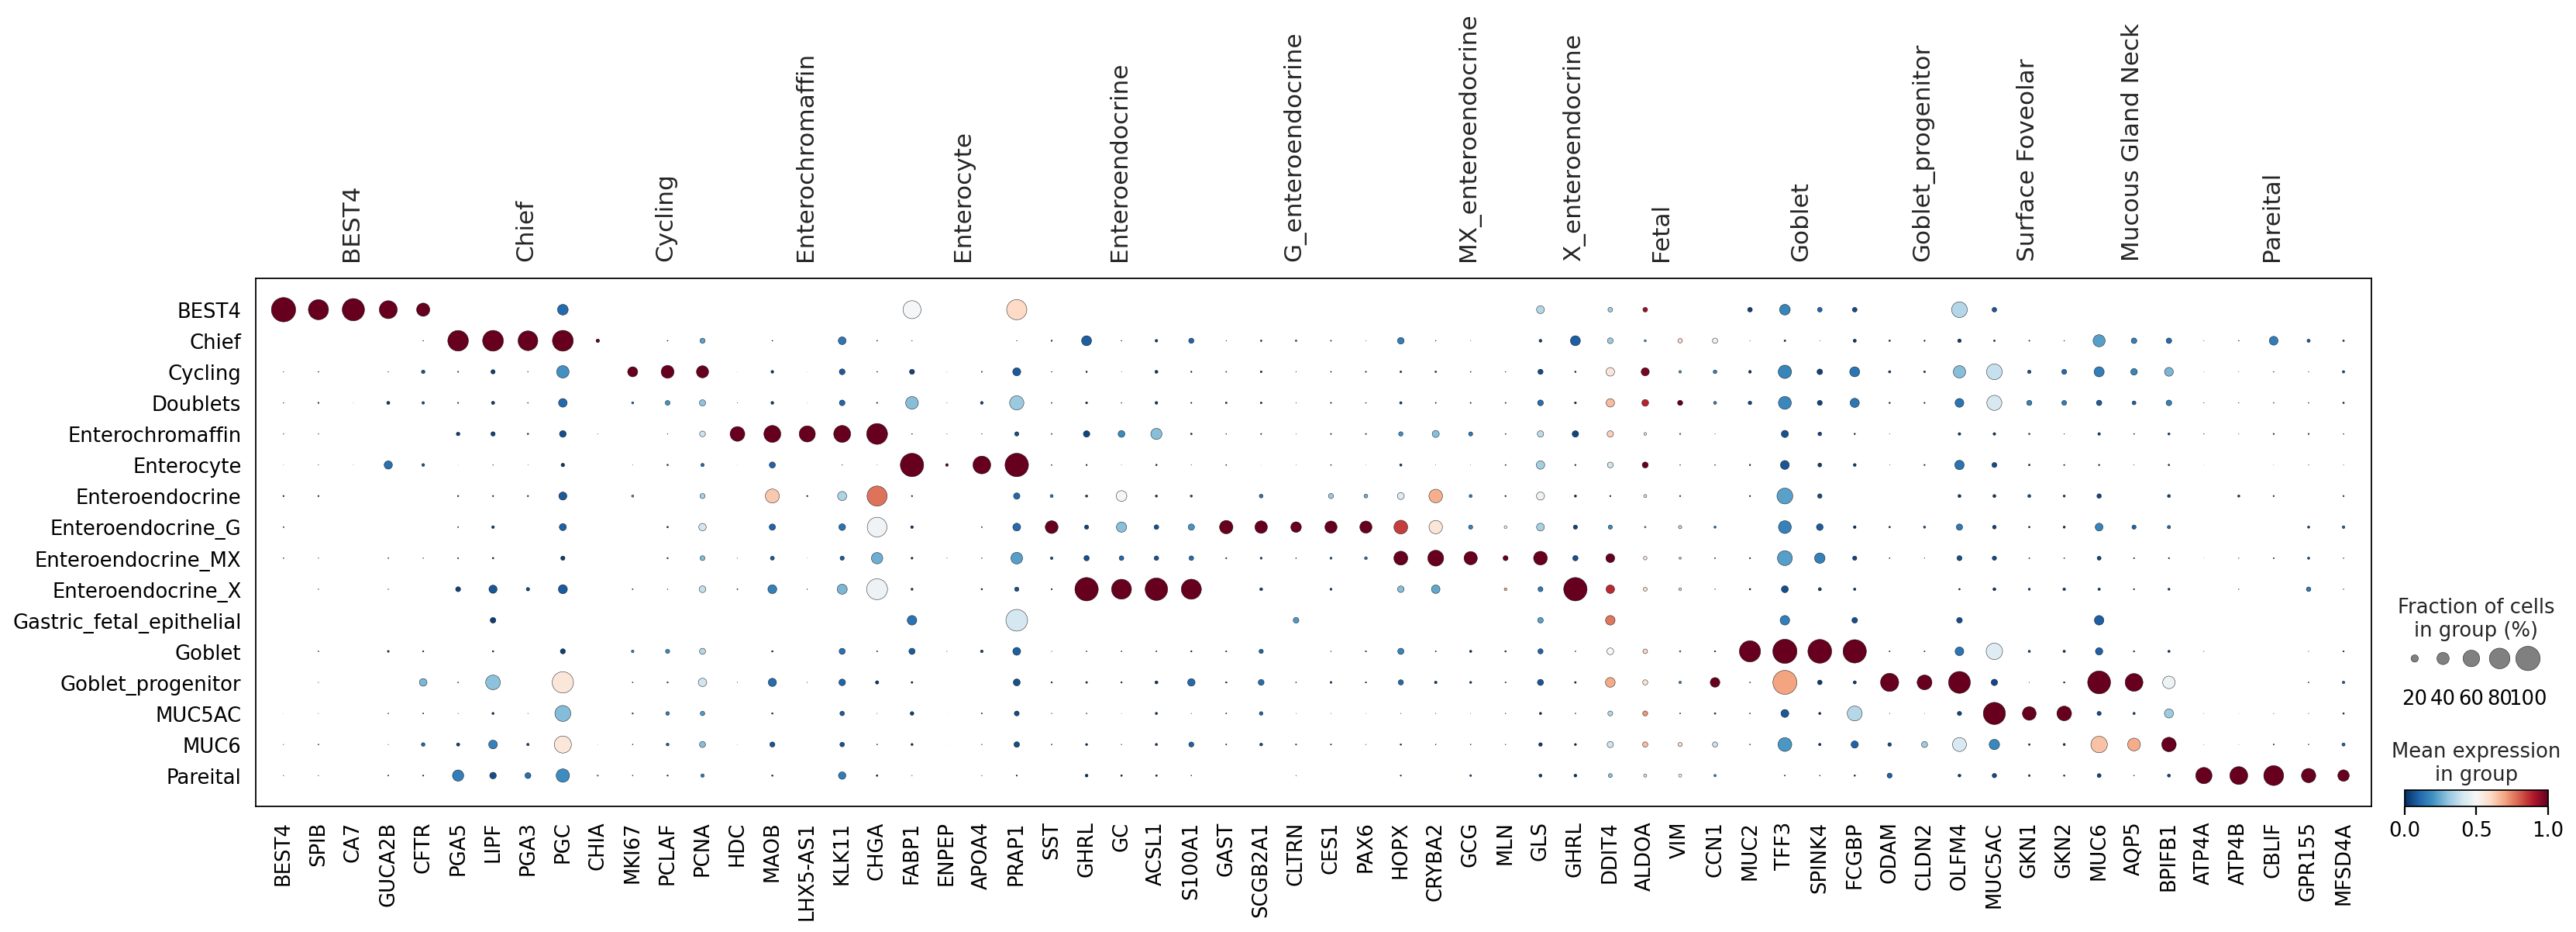

In [34]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

In [35]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [36]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.480283260345459


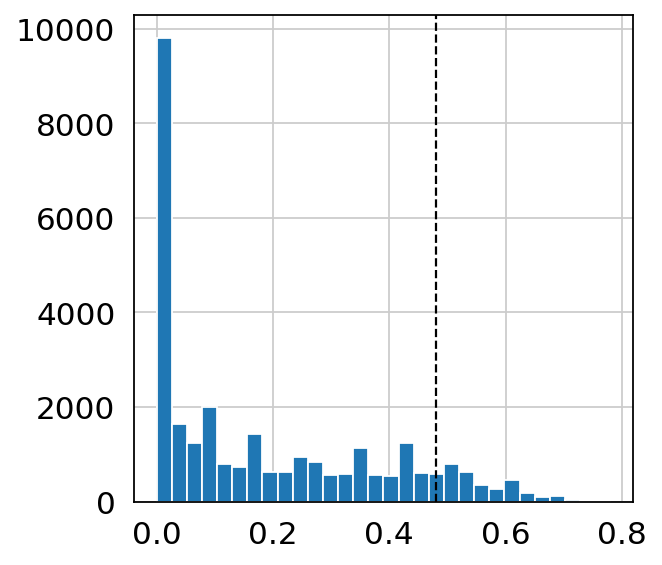

In [37]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('Epi_stomach_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [38]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-38-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [39]:
adata.obs['disease'].unique()

['cancer_gastric']
Categories (1, object): ['cancer_gastric']

In [40]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.46, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [41]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

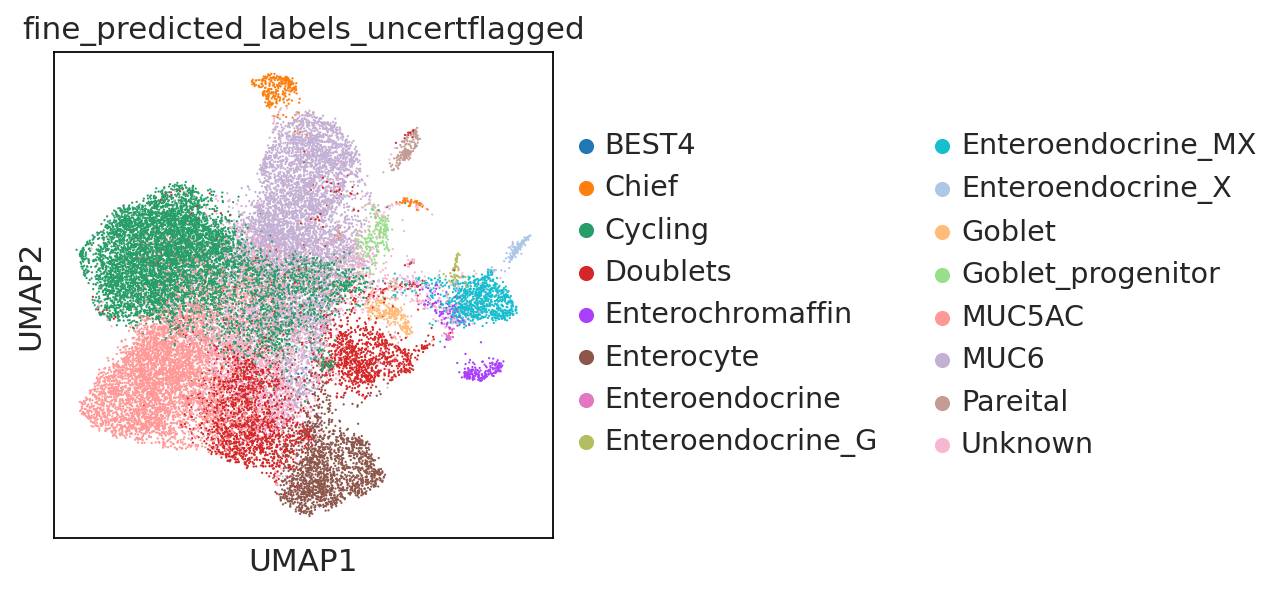

In [42]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

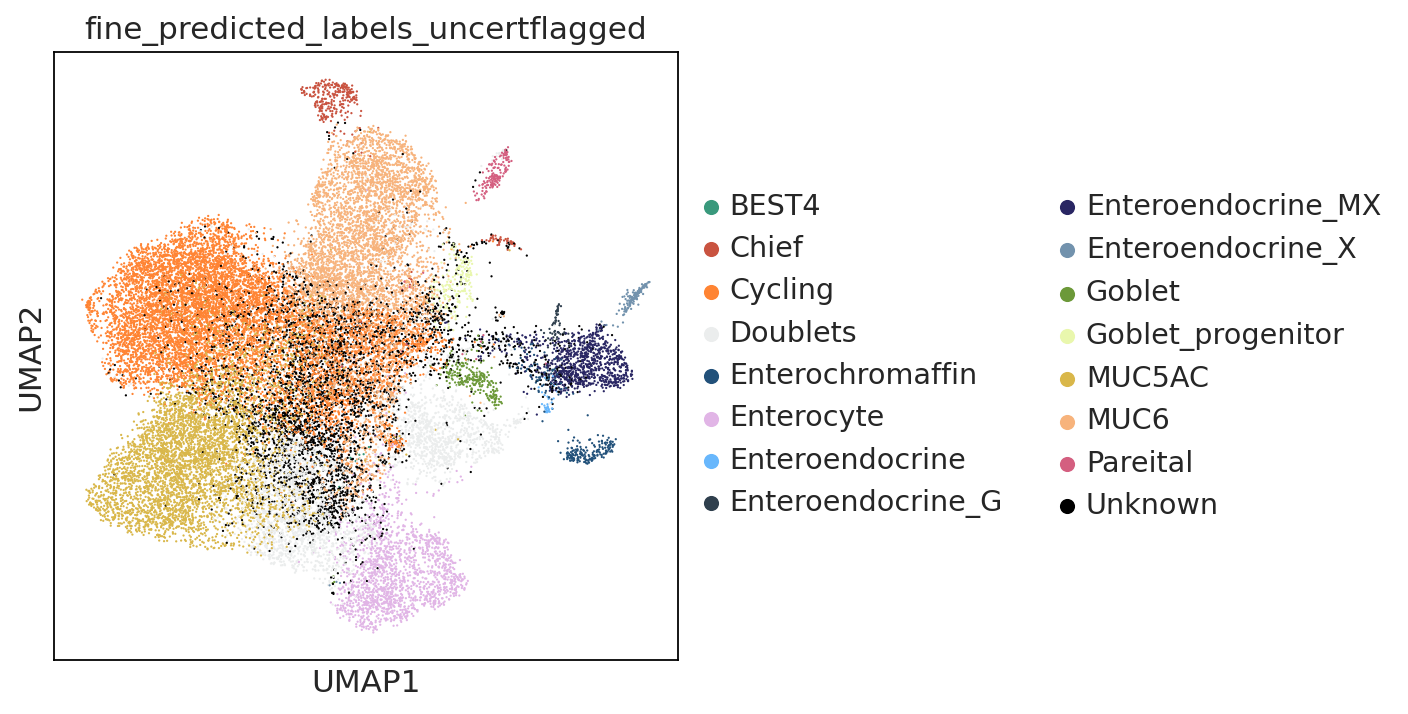

In [43]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#39997c',#BEST4
                                            '#c95340',#chief
                                            '#ff8433',#'Cycling'
                                            '#ebeded',#doublets
                                           '#22517a',#enterochromaffin
                                            '#e1b5e6',#enterocyte
                                           '#68b7fc',#enteroendocrine
                                            '#2f3f4d',#G_enteroendocrine
                                            '#292663',#MX enteroendocrine
                                            '#7292ad',#X_enteroendocrine
                                            '#6c9939',#goblet
                                            '#e9f7ad',#goblet progenitor
                                            '#d9b74a',#MUC5AC
                                            '#f7b37c',#MUC6
                                           '#d45f80',#pareital 
                                                          '#000000',#unknown
                                               
                                               
    
    
                                              ],save='Epi_stomach_scanviannot_uncert.pdf')

In [44]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/epi_stomach_disease_annot.csv',index_col=0)

In [45]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

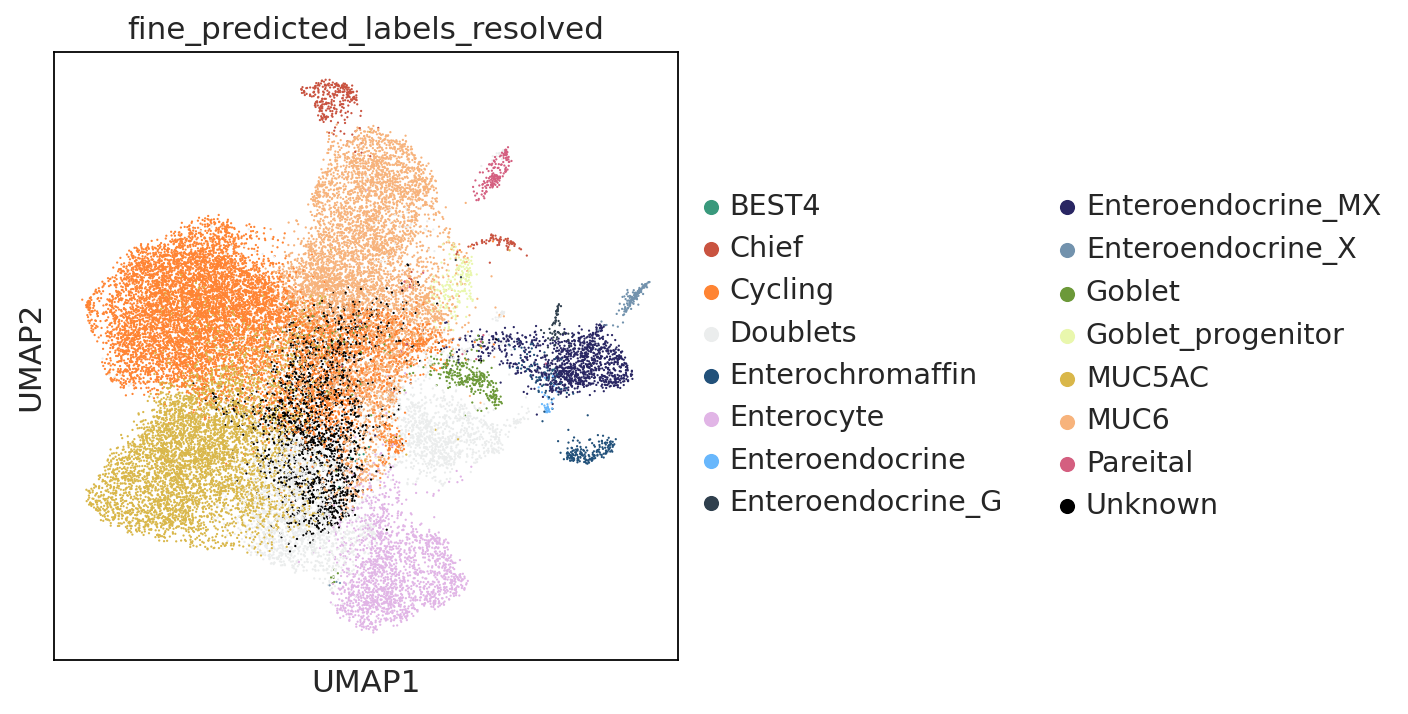

In [46]:
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#39997c',#BEST4
                                            '#c95340',#chief
                                            '#ff8433',#'Cycling'
                                            '#ebeded',#doublets
                                           '#22517a',#enterochromaffin
                                            '#e1b5e6',#enterocyte
                                           '#68b7fc',#enteroendocrine
                                            '#2f3f4d',#G_enteroendocrine
                                            '#292663',#MX enteroendocrine
                                            '#7292ad',#X_enteroendocrine
                                            '#6c9939',#goblet
                                            '#e9f7ad',#goblet progenitor
                                            '#d9b74a',#MUC5AC
                                            '#f7b37c',#MUC6
                                           '#d45f80',#pareital 
                                            '#000000',#unknown
                                               
                                               
    
    
                                              ],save='Epi_stomach_scanviannot_resolved.pdf')

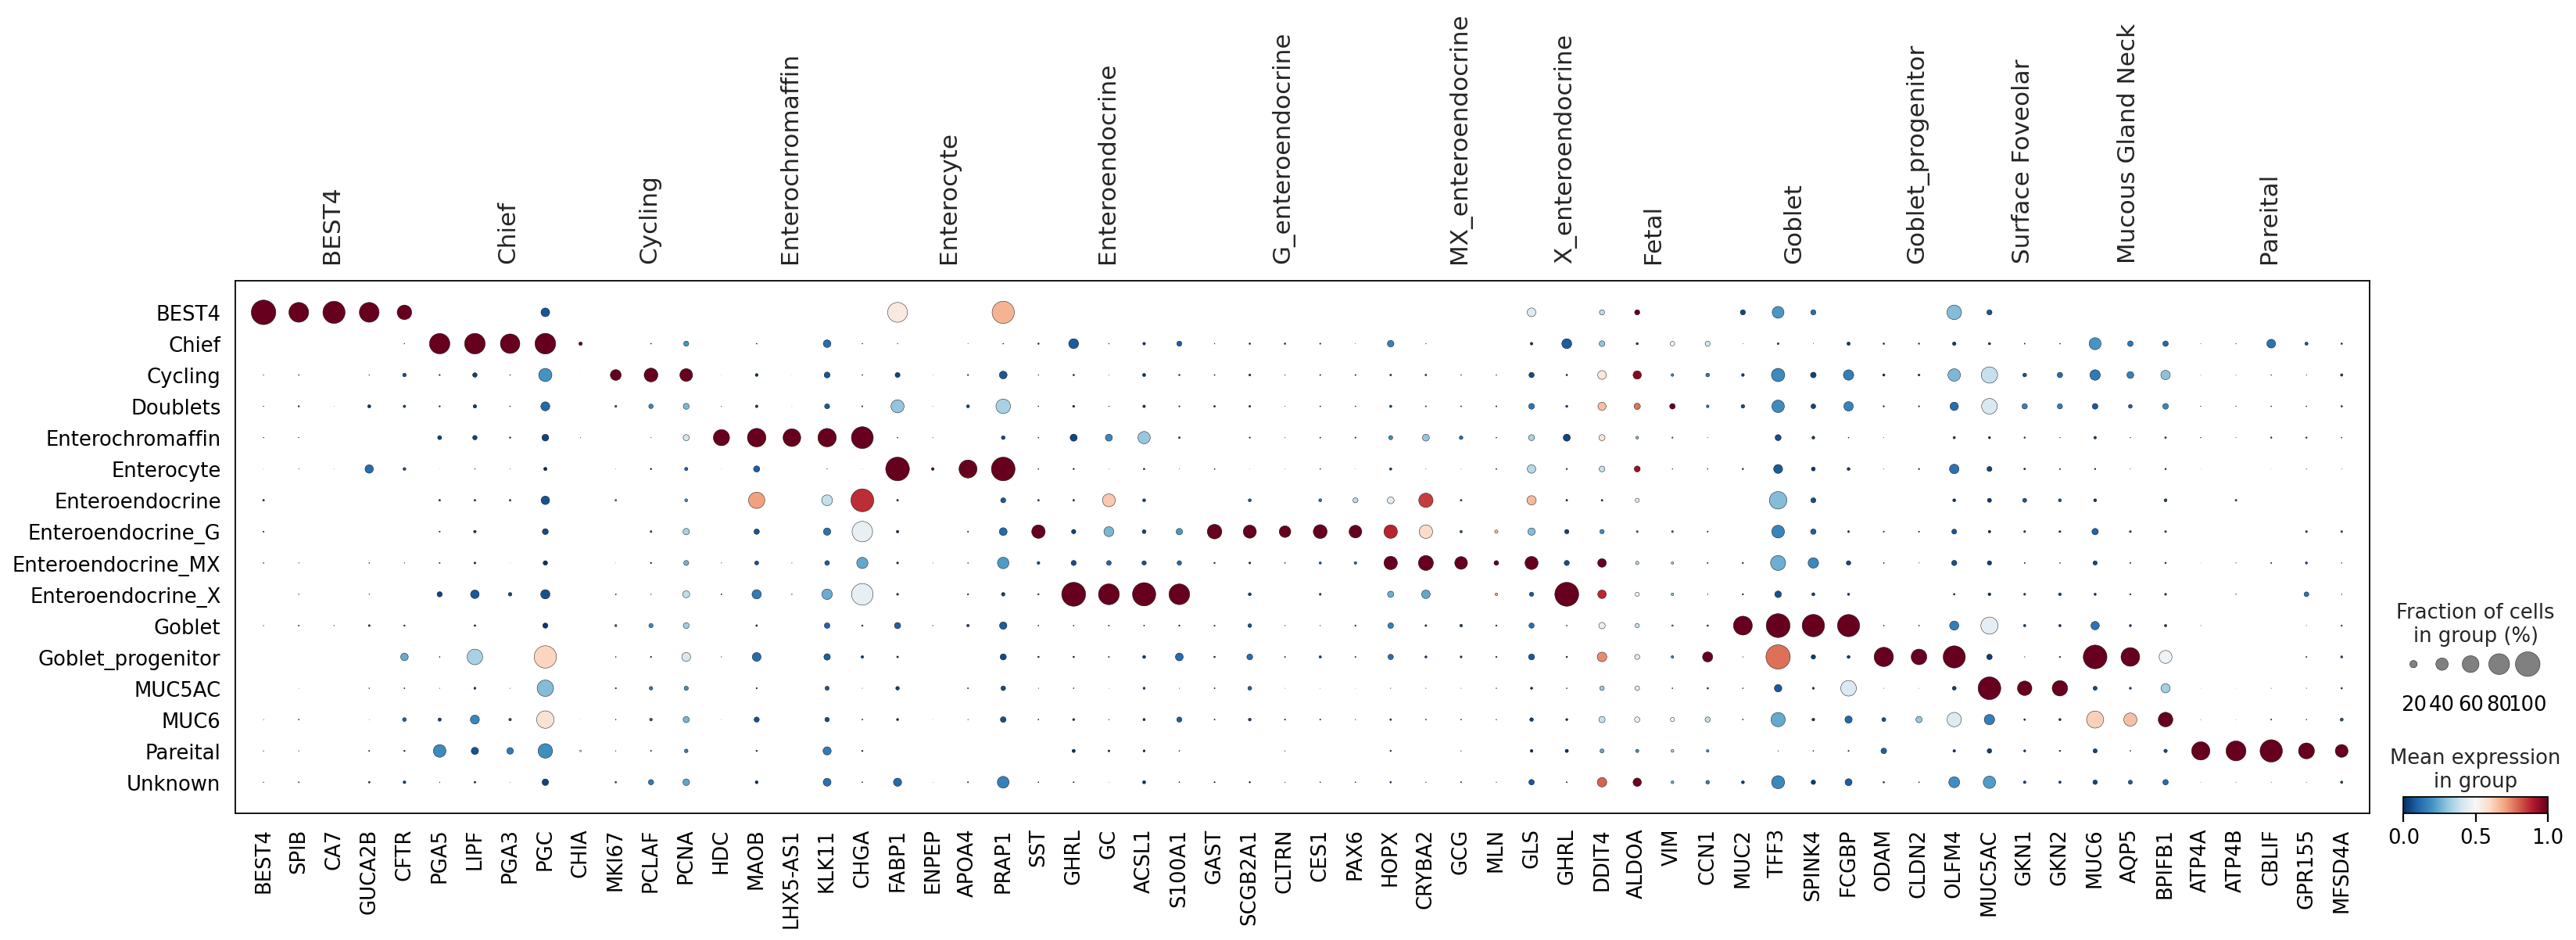

In [47]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='Epi_stomach_scanviannot_resvoledmarkers.pdf')

In [48]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'MUC5AC': '#d9b74a',
  'MUC6': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

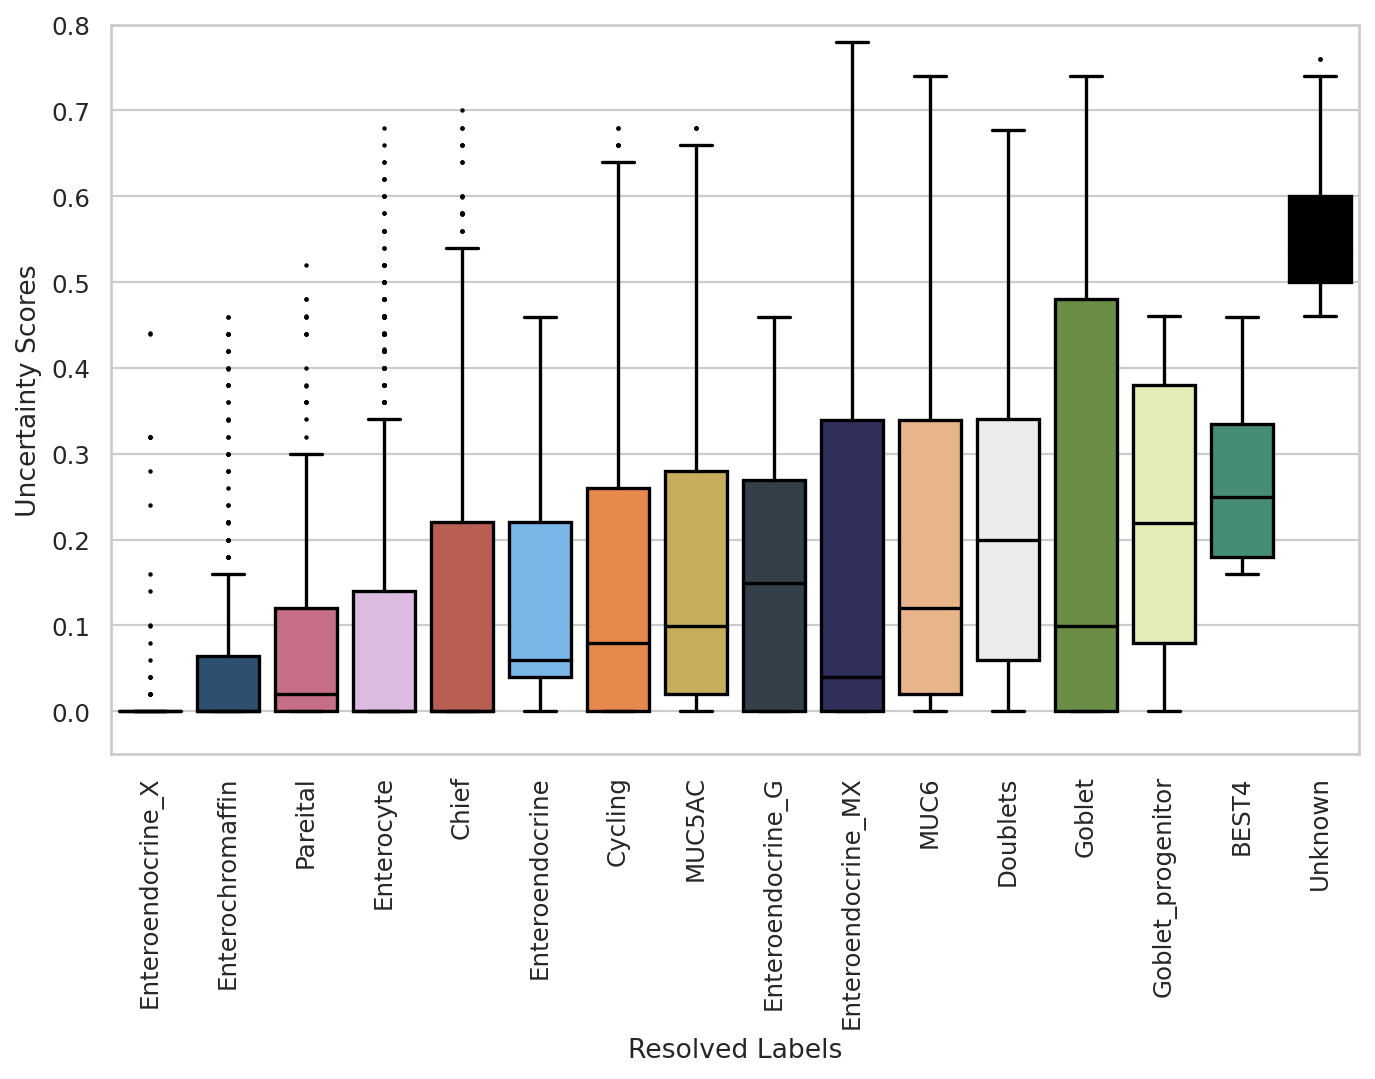

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('Epi_stomach_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

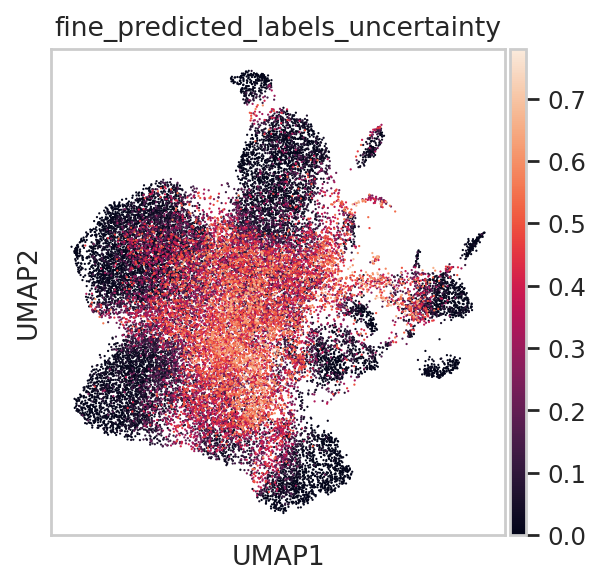

In [50]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='Epi_stomach_scanviannot_uncertainty.pdf')

In [51]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [52]:
adata

AnnData object with n_obs × n_vars = 29381 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [53]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [54]:
adata.obs['unknown_clusterlabel'].value_counts()

Cycling_Cycling                          8272
MUC6_MUC6                                5394
MUC5AC_MUC5AC                            4802
Doublets_Doublets                        3040
Unknown_Unknown                          1846
Enterocyte_Enterocyte                    1688
Enteroendocrine_MX_Enteroendocrine_MX     929
Unknown_MUC6                              742
Unknown_Cycling                           387
Chief_Chief                               322
Unknown_MUC5AC                            319
Enterochromaffin_Enterochromaffin         272
Goblet_Goblet                             250
Unknown_Enteroendocrine_MX                208
Goblet_progenitor_Goblet_progenitor       197
Pareital_Pareital                         174
Enteroendocrine_X_Enteroendocrine_X       143
Unknown_Goblet                             94
Unknown_Doublets                           89
Unknown_Enterocyte                         81
Enteroendocrine_G_Enteroendocrine_G        60
Enteroendocrine_Enteroendocrine   

In [55]:
adata.X.max()

9.039762

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank

         Falling back to preprocessing with `sc.pp.pca` and default params.


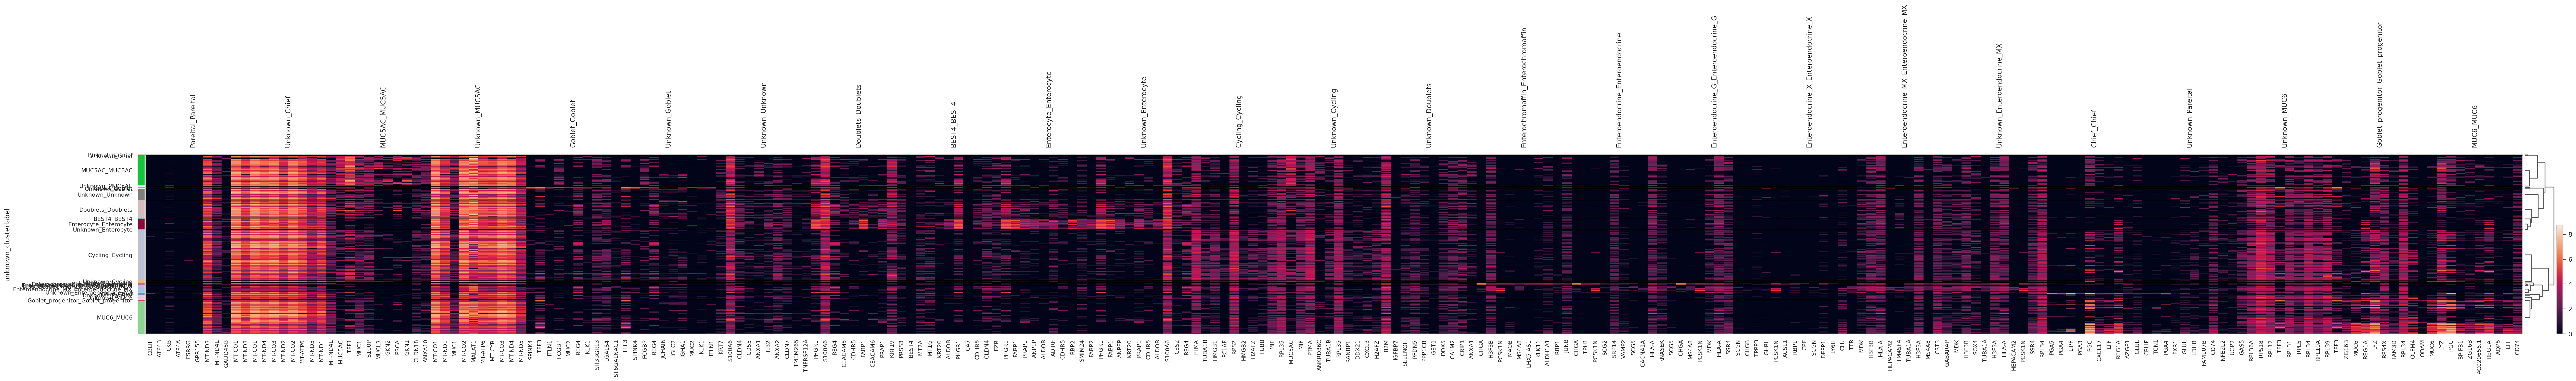

In [57]:
sc.tl.rank_genes_groups(adata, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True)

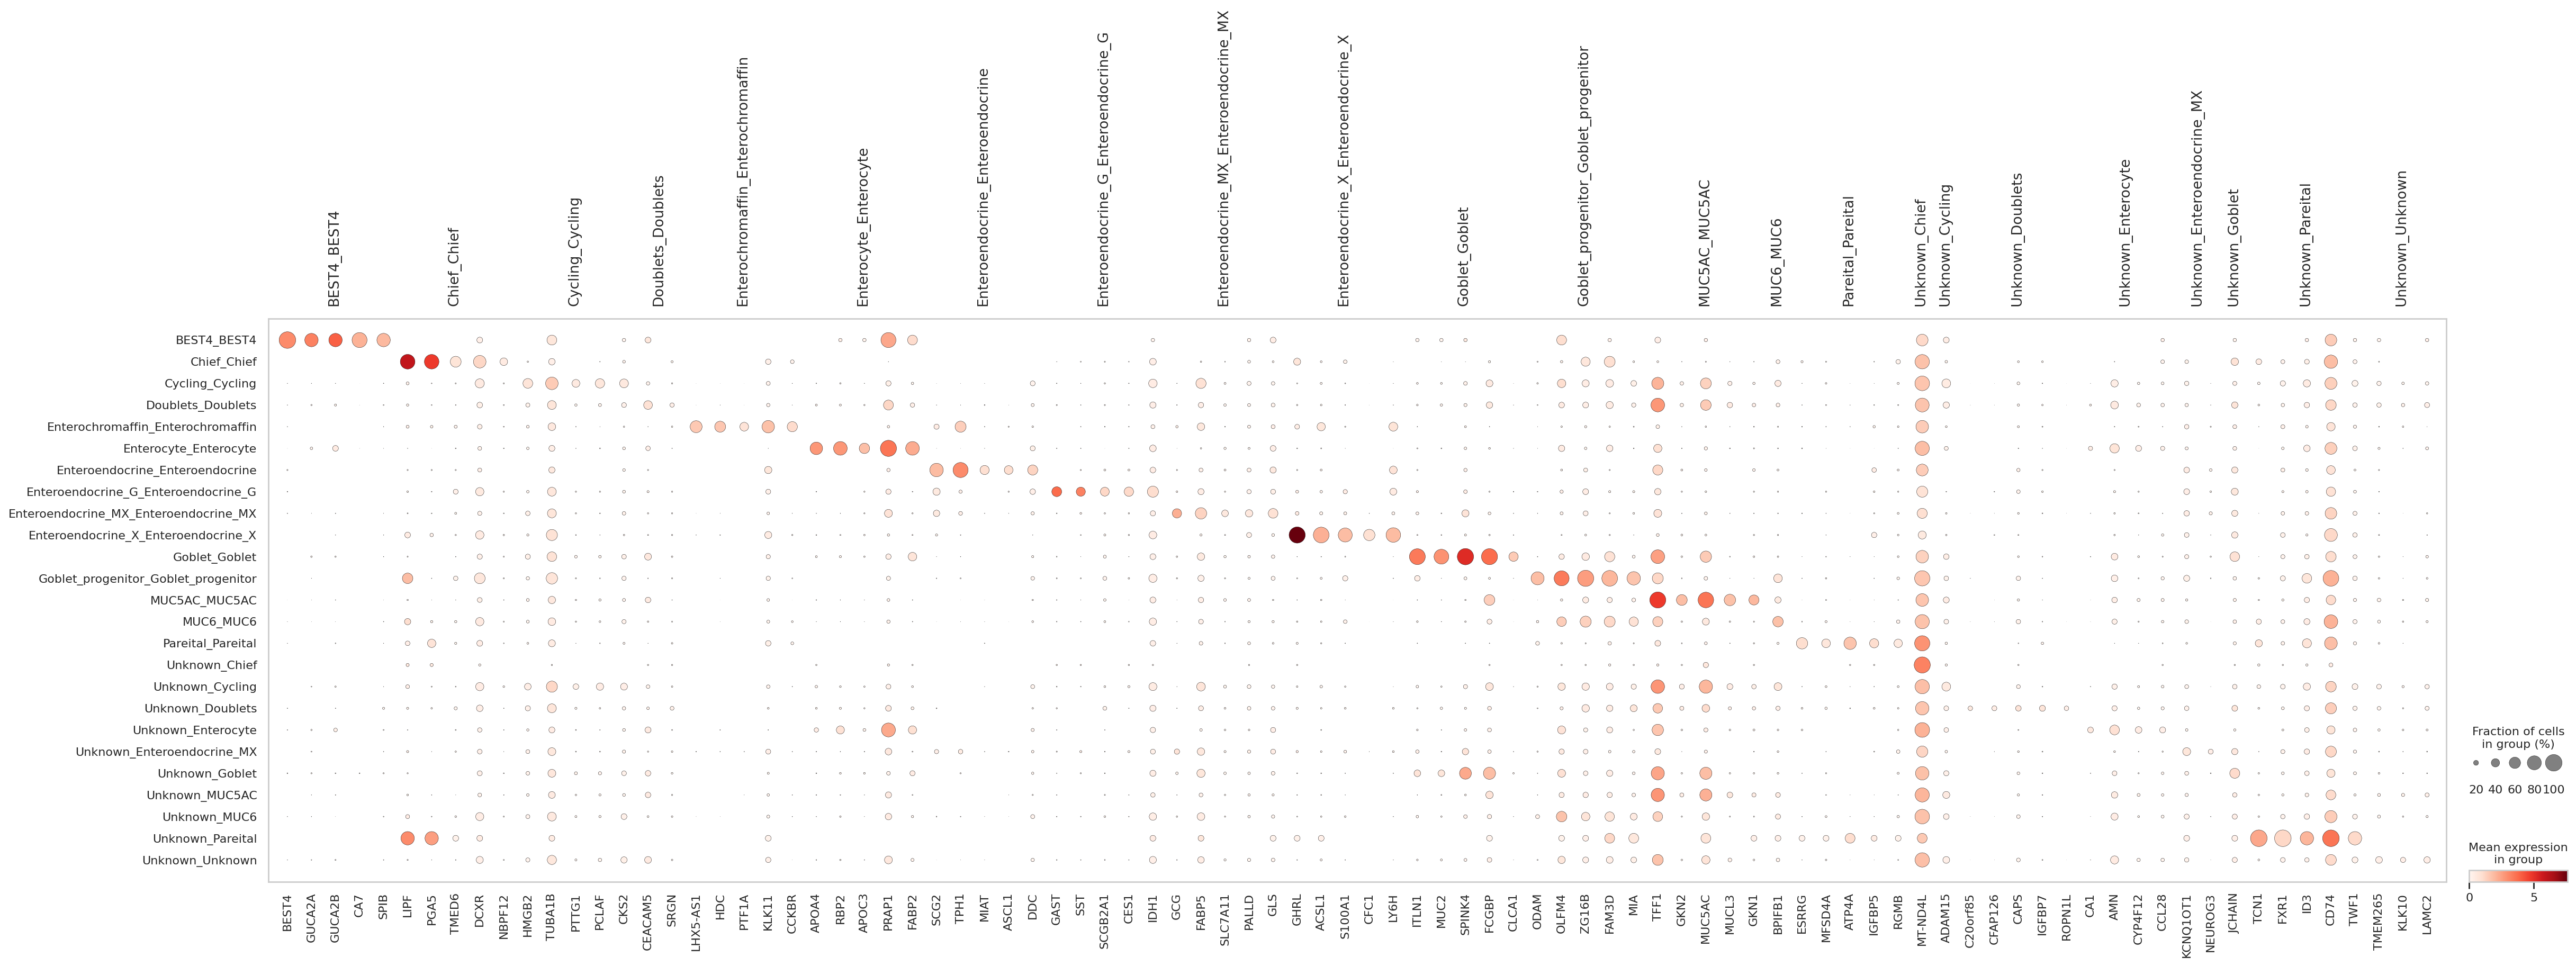

In [58]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks)

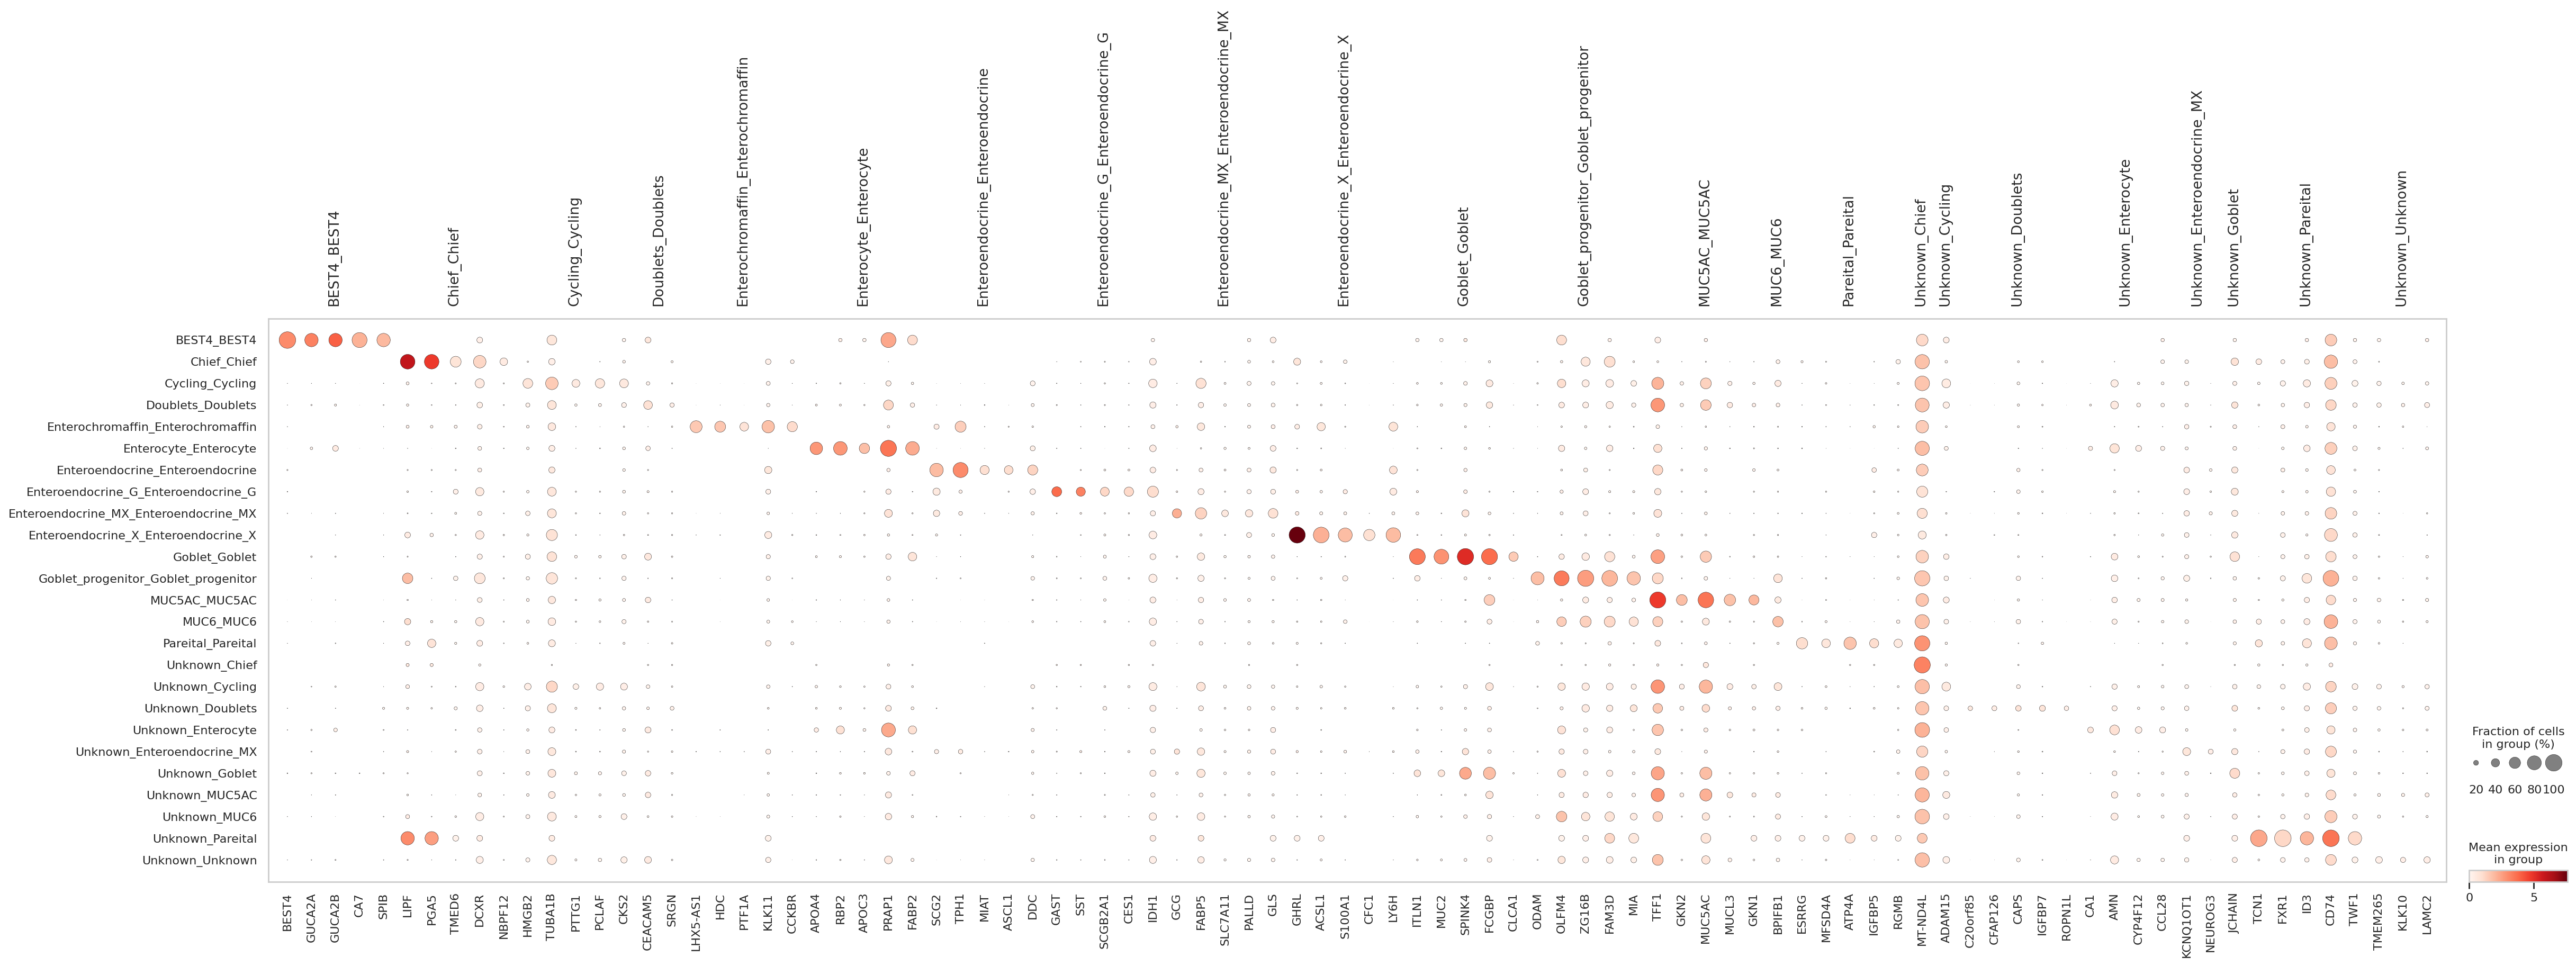

In [59]:
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks,save='Epi_stomach_unknown_specificDGE.pdf')